In [1]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import convolve, rotate
import os
import glob
import math


# Function to generate a Gaussian kernel
def gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    sum_val = 0
    for i in range(size):
        for j in range(size):
            diff = (i - center)**2 + (j - center)**2
            kernel[i, j] = np.exp(-diff / (2 * sigma**2))
            sum_val += kernel[i, j]
    return kernel / sum_val


#TODO: Implement the convolution function custom
def convolve(image, kernel):
    return cv2.filter2D(image, -1, kernel)



def generate_gaussian_pyramid(image, num_octaves, num_levels, size, initial_sigma):
    pyramid = []
    k = 2 ** (1.0 / num_levels)  # Scale multiplication factor
    for octave in range(num_octaves):
        octave_images = []
        sigma = initial_sigma
        for level in range(0,num_levels):
            kernel = gaussian_kernel(size, sigma)
            smoothed_image = convolve(image, kernel)
            octave_images.append(smoothed_image)
            sigma *= k
        pyramid.append(octave_images)
        # Downsample image for the next octave
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2))
    return pyramid


def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    if min_val == max_val:
        return image
    normalized_image = ((image - min_val) / (max_val - min_val)) * 255
    return normalized_image.astype(np.uint8)

def generate_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for octave_images in gaussian_pyramid:
        dog_images = []
        for i in range(1, len(octave_images)):
            dog = octave_images[i] - octave_images[i - 1]
            normalized_dog = normalize_image(dog)
            dog_images.append(normalized_dog)
        dog_pyramid.append(dog_images)
    return dog_pyramid



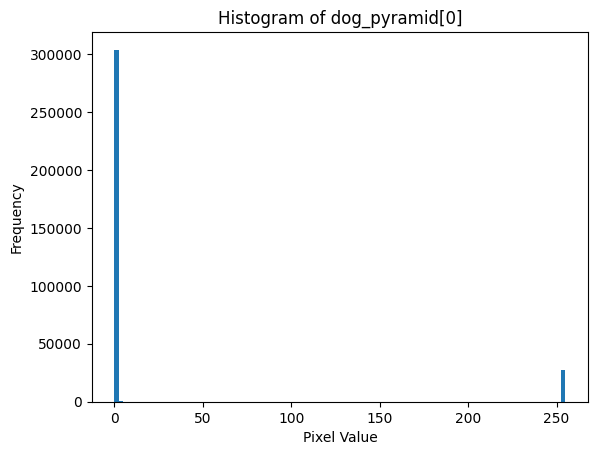

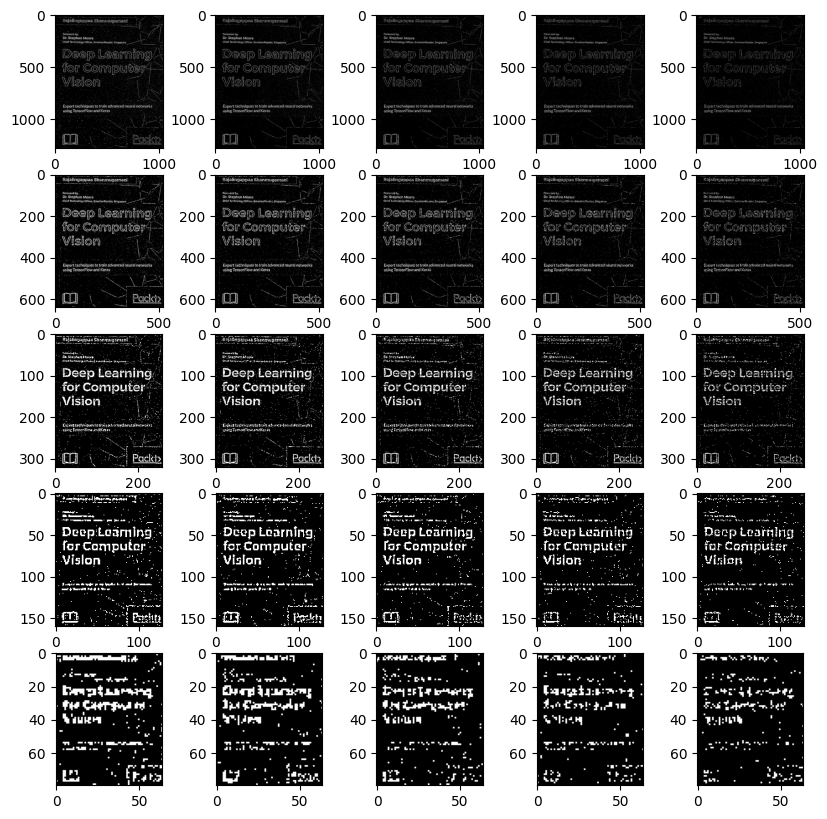

In [112]:
# Read the image
image = cv2.imread("book.jpg", cv2.IMREAD_GRAYSCALE)


initial_sigma = 1.6
num_octaves = 5
num_levels = 6
size = 5

gaussian_pyramid = generate_gaussian_pyramid(image, num_octaves, num_levels, size, initial_sigma)
dog_pyramid = generate_dog_pyramid(gaussian_pyramid)


plt.hist(dog_pyramid[1][0].flatten(), bins=100)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of dog_pyramid[0]')
plt.show()

# Show all images in dog_pyramid in a subplot
fig, axs = plt.subplots(len(dog_pyramid), len(dog_pyramid[0]), figsize=(10, 10))
for i in range(len(dog_pyramid)):
    for j in range(len(dog_pyramid[i])):
        axs[i, j].imshow(dog_pyramid[i][j], cmap='gray')
plt.show()



Image size:  (600, 400)
Image size:  (300, 200)
Image size:  (150, 100)
Image size:  (75, 50)
Image size:  (37, 25)
Image size:  (18, 12)


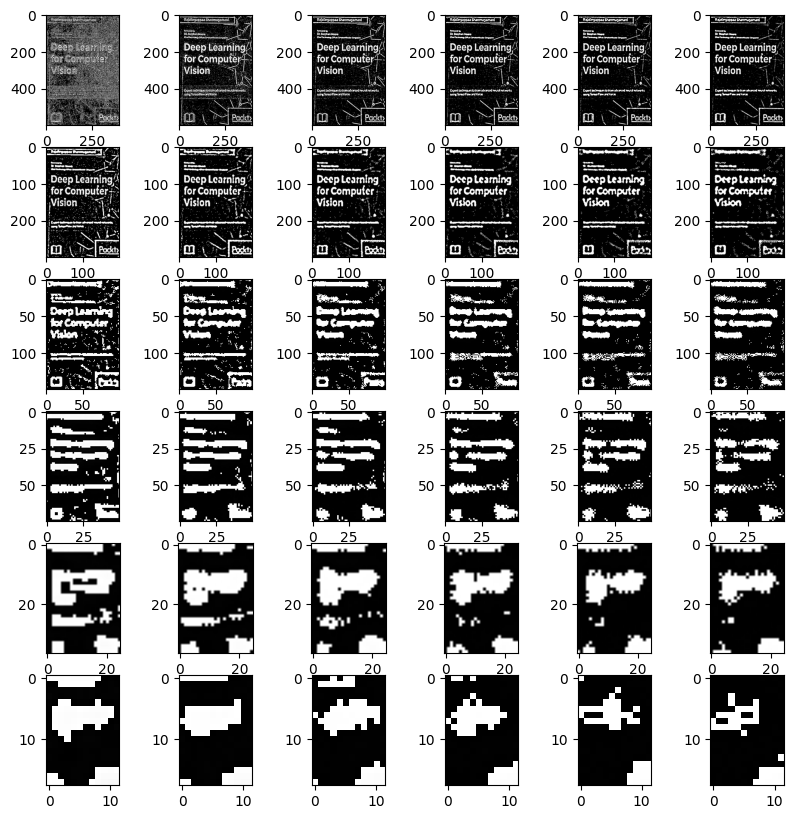

In [51]:
import numpy as np
import cv2

# Function to generate Gaussian kernel
def gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    for i in range(size):
        for j in range(size):
            diff = (i - center)**2 + (j - center)**2
            kernel[i, j] = np.exp(-diff / (2 * sigma**2))
    return kernel / np.sum(kernel)

# Function to convolve image with a kernel
def convolve(image, kernel):
    return cv2.filter2D(image, -1, kernel, borderType=cv2.BORDER_REFLECT)

# Function to generate Gaussian pyramid
def generate_gaussian_pyramid(image, num_octaves, num_scales):
    gaussian_pyramid = []
    for _ in range(num_octaves):
        octave_images = [image]
        for _ in range(num_scales):
            image = convolve(image, gaussian_kernel(5, 1.6))
            octave_images.append(image)
        gaussian_pyramid.append(octave_images)
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2))
    return gaussian_pyramid

# Function to generate Difference of Gaussians (DoG) pyramid
def generate_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for octave_images in gaussian_pyramid:
        dog_images = []
        for i in range(1, len(octave_images)):
            dog = octave_images[i] - octave_images[i - 1]
            dog_images.append(dog)
        dog_pyramid.append(dog_images)
    return dog_pyramid

image = cv2.imread("book.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (400, 600))
gaussian_pyramid = generate_gaussian_pyramid(image, num_octaves=6, num_scales=6)
dog_pyramid = generate_dog_pyramid(gaussian_pyramid)

# Show all images in dog_pyramid in a subplot
fig, axs = plt.subplots(len(dog_pyramid), len(dog_pyramid[0]), figsize=(10, 10))
for i in range(len(dog_pyramid)):
    print("Image size: ", dog_pyramid[i][0].shape)
    for j in range(len(dog_pyramid[i])):
        axs[i, j].imshow(dog_pyramid[i][j], cmap='gray')
plt.show()



In [64]:
def get_pixel_cube(dog_images_octave, i, j, level):
    cube = []
    for x in range(-1, 2):
        cube.append(dog_images_octave[level+x][i-1:i+2, j-1:j+2])
    return np.concatenate(cube).ravel()


def is_extremum(dog_images_octave, i, j, level):
    center_pixel = dog_images_octave[level][i, j]
    cube = get_pixel_cube(dog_images_octave, i, j, level)
    if center_pixel == np.max(cube) or center_pixel == np.min(cube):
        return True
    return False


def detect_extrema(dog_pyramid):
    extrema_blocks = []
    for octave, octave_images in enumerate(dog_pyramid):
        extrema_locations = set() 
        for level, image in enumerate(octave_images):
            if level != 0 and level != len(octave_images) - 1:
                print(f"Processing octave {octave}, level {level}")
                for i in range(1, image.shape[0] - 2):
                    for j in range(1, image.shape[1] - 2):
                        if is_extremum(dog_pyramid[octave], i, j, level):
                            extrema_locations.add((i, j))
        extrema_blocks.append(list(extrema_locations))  # Convert the set back to a list
    return extrema_blocks


extrema_blocks = detect_extrema(dog_pyramid)


Processing octave 0, level 1
Processing octave 0, level 2
Processing octave 0, level 3
Processing octave 0, level 4
Processing octave 1, level 1
Processing octave 1, level 2
Processing octave 1, level 3
Processing octave 1, level 4
Processing octave 2, level 1
Processing octave 2, level 2
Processing octave 2, level 3
Processing octave 2, level 4
Processing octave 3, level 1
Processing octave 3, level 2
Processing octave 3, level 3
Processing octave 3, level 4
Processing octave 4, level 1
Processing octave 4, level 2
Processing octave 4, level 3
Processing octave 4, level 4
Processing octave 5, level 1
Processing octave 5, level 2
Processing octave 5, level 3
Processing octave 5, level 4


In [63]:
print((extrema_blocks[4]))

[(15, 21), (26, 21), (18, 17), (27, 4), (27, 13), (19, 9), (30, 9), (8, 9), (11, 5), (8, 18), (30, 18), (19, 18), (11, 14), (4, 2), (34, 3), (22, 10), (34, 12), (3, 6), (22, 19), (3, 15), (14, 15), (15, 7), (26, 7), (7, 3), (18, 3), (26, 16), (15, 16), (7, 12), (18, 21), (7, 21), (27, 8), (8, 4), (19, 4), (30, 4), (30, 13), (11, 9), (33, 6), (33, 15), (25, 11), (10, 22), (25, 20), (34, 7), (22, 5), (3, 1), (14, 1), (34, 16), (22, 14), (3, 10), (14, 10), (3, 19), (14, 19), (15, 2), (26, 2), (15, 11), (26, 11), (18, 7), (7, 7), (26, 20), (18, 16), (29, 13), (29, 22), (21, 18), (11, 4), (33, 1), (10, 8), (33, 10), (25, 6), (10, 17), (33, 19), (25, 15), (2, 13), (2, 22), (34, 2), (34, 11), (22, 9), (14, 5), (3, 5), (22, 18), (3, 14), (14, 14), (15, 6), (26, 6), (18, 2), (18, 11), (29, 8), (29, 17), (6, 15), (21, 13), (21, 22), (33, 5), (10, 3), (25, 1), (10, 12), (33, 14), (2, 8), (25, 10), (10, 21), (2, 17), (25, 19), (34, 6), (22, 4), (22, 13), (14, 9), (3, 9), (3, 18), (14, 18), (26, 1)